In [3]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

In [4]:
def load_mnist(batch_size=32, shuffle_size=100):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)

    x_train = x_train.reshape(-1, 28 * 28)
    x_test = x_test.reshape(-1, 28 * 28)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffle_size).batch(batch_size, drop_remainder=True)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffle_size).batch(batch_size, drop_remainder=True)
    return train_dataset, test_dataset

In [5]:
def load_cifar(batch_size=32, shuffle_size=100):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)

    x_train = x_train.reshape(-1, 32 * 32 * 3)
    x_test = x_test.reshape(-1, 32 * 32 * 3)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffle_size).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffle_size).batch(batch_size)
    return train_dataset, test_dataset

** I. Define the Mixture of Experts (MoE) Model**

In [14]:
def get_experts(n_experts, input_shape=(28 * 28,)):
    return [keras.Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
    ]) for _ in range(n_experts)]

def get_gate(n_experts, input_shape=(28 * 28,)):
    return keras.Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(n_experts, activation='softmax')
    ])

class MOE_Model(keras.Model):
    def __init__(self, experts, gate, optimizer=None):
        super(MOE_Model, self).__init__()
        self.experts = experts
        self.gate = gate
        self.optimizer = optimizer if optimizer else keras.optimizers.Adam(0.001)

    # def call(self, inputs):
    #     gates = tf.expand_dims(self.gate(inputs), -1)
    #     values = tf.stack([expert(inputs) for expert in self.experts], axis=-1)
    #     return tf.matmul(values, gates)

    def call(self, inputs):
        # Gate outputs weights for each expert
        gates = self.gate(inputs)  # Shape: (batch_size, n_experts)

        # Experts outputs predictions for each input
        values = tf.stack([expert(inputs) for expert in self.experts], axis=-1)  # Shape: (batch_size, 10, n_experts)

        # Combine experts' predictions weighted by the gate
        weighted_sum = tf.reduce_sum(values * tf.expand_dims(gates, axis=1), axis=-1)  # Shape: (batch_size, 10)

        return weighted_sum

In [18]:
# def train_model(model, dataset, epochs, test_dataset=None, wandb_config=None):
#     if wandb_config is not None:
#         import wandb
#         from wandb.keras import WandbCallback
#         wandb.init(project='mixture-of-experts', config=wandb_config)
#         model.fit(dataset, epochs=epochs, validation_data=test_dataset, callbacks=[WandbCallback(save_weights_only=True, log_batch_frequency=128)])
#     else:
#         model.fit(dataset, epochs=epochs, validation_data=test_dataset)

def train_model(model, dataset, epochs, test_dataset=None):
    history = model.fit(dataset, epochs=epochs, validation_data=test_dataset)
    return history

In [10]:
# Define parameters
n_experts = 5  # Number of experts in the model
dataset_name = 'CIFAR10'  # Choose between 'MNIST' and 'CIFAR10'
epochs = 10  # Number of epochs
use_wandb = False  # Set True if using Weights and Biases for tracking

# Load the dataset
if dataset_name == 'MNIST':
    input_shape = (28 * 28,)
    train_data, test_data = load_mnist()
else:
    input_shape = (32 * 32 * 3,)
    train_data, test_data = load_cifar()


In [11]:
for x_batch, y_batch in train_data.take(1):
    print("Input batch shape:", x_batch.shape)
    print("Label batch shape:", y_batch.shape)


Input batch shape: (32, 3072)
Label batch shape: (32, 10)


In [19]:
# Initialize the model
experts = get_experts(n_experts, input_shape)
gate = get_gate(n_experts, input_shape)
m = MOE_Model(experts, gate)
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 25ms/step - categorical_accuracy: 0.2684 - loss: 1.9749 - val_categorical_accuracy: 0.3535 - val_loss: 1.7607
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - categorical_accuracy: 0.3616 - loss: 1.7514 - val_categorical_accuracy: 0.3881 - val_loss: 1.6963
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - categorical_accuracy: 0.3843 - loss: 1.6975 - val_categorical_accuracy: 0.3973 - val_loss: 1.6759
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - categorical_accuracy: 0.3978 - loss: 1.6636 - val_categorical_accuracy: 0.4012 - val_loss: 1.6509
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - categorical_accuracy: 0.4073 - loss: 1.6370 - val_categorical_accuracy: 0.4084 - val_loss: 1.6378
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - categorical_accuracy: 0.4120 - loss: 1.6282 - val_categorical_accuracy: 0.4053 - val_loss: 1.6380
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - catego

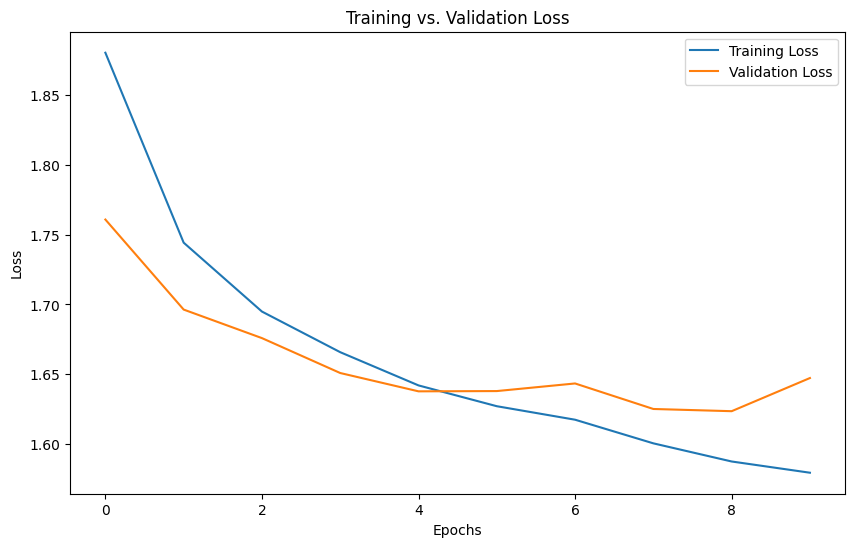

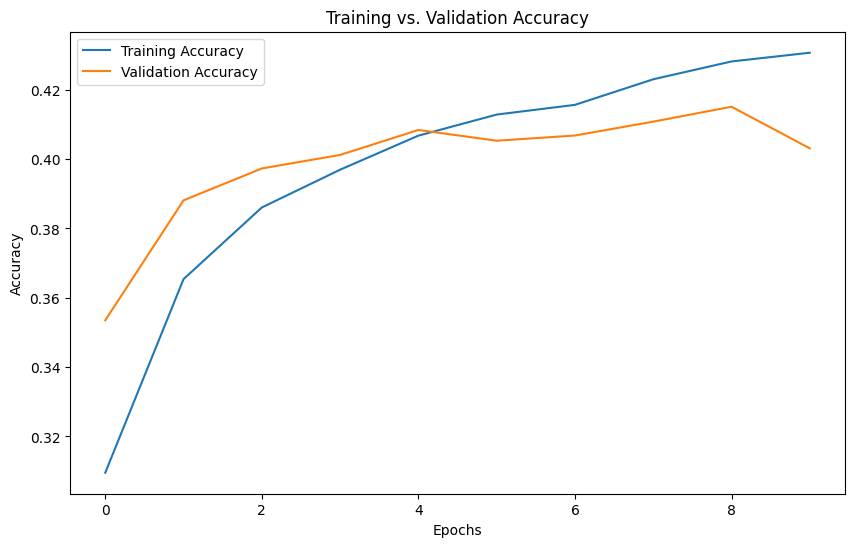

In [20]:
import matplotlib.pyplot as plt

# Train the model
history = train_model(m, train_data, epochs, test_data)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

In [25]:
# Visualize with wandb
!pip install wandb
!wandb login

wandb: Currently logged in as: khanhbq269 (khanhbq269-vnu). Use `wandb login --relogin` to force relogin


In [29]:
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

def train_model_2(model, dataset, epochs, test_dataset=None, wandb_config=None):
    if wandb_config is not None:
        import wandb
        wandb.init(project='mixture-of-experts', config=wandb_config)

        # Configure callbacks
        metrics_logger = WandbMetricsLogger()
        model_checkpoint = WandbModelCheckpoint(filepath="model-best.keras", save_freq="epoch")

        # Train with new callbacks
        model.fit(dataset, epochs=epochs, validation_data=test_dataset, callbacks=[metrics_logger, model_checkpoint])
    else:
        model.fit(dataset, epochs=epochs, validation_data=test_dataset)

wandb_config = {'Experts': n_experts, 'Dataset': dataset_name, 'Epochs': epochs}
train_model_2(m, train_data, epochs, test_data, wandb_config=wandb_config)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - categorical_accuracy: 0.4412 - loss: 1.5464 - val_categorical_accuracy: 0.4237 - val_loss: 1.6057
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - categorical_accuracy: 0.4452 - loss: 1.5360 - val_categorical_accuracy: 0.4102 - val_loss: 1.6439
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - categorical_accuracy: 0.4495 - loss: 1.5280 - val_categorical_accuracy: 0.4253 - val_loss: 1.6092
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - categorical_accuracy: 0.4481 - loss: 1.5240 - val_categorical_accuracy: 0.4182 - val_loss: 1.6349
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - categorical_accuracy: 0.4539 - loss: 1.5187 - val_categorical_accuracy: 0.4124 - val_loss: 1.6489
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - categorical_accuracy: 0.4545 - loss: 1.5132 - val_categorical_accuracy: 0.4183 - val_loss: 1.6508
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - catego